In [1]:
import pandas as pd
import numpy as np
import recmetrics
import matplotlib.pyplot as plt
from surprise import Reader, SVD, Dataset
from surprise.model_selection import train_test_split

# MovieLense Dataset
Using the MovieLens 20M Dataset dataset for examples. You can download this data here: https://grouplens.org/datasets/movielens/20m/

In [2]:
ratings = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/ratings.csv')
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

In [3]:
#only consider ratings from users who have rated over n movies
n=1000
users = ratings.userId.value_counts()
users = users[users>n].index.tolist()

In [4]:
ratings = ratings.query('userId in @users')
print ratings.shape
ratings.head(3)

(1317902, 4)


,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803


In [5]:
# get movie features

rated_movies = ratings.movieId.tolist()
movies = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/movies.csv')
movies = movies.query('movieId in @rated_movies')
movies.set_index("movieId", inplace=True, drop=True)

movies = movies.genres.str.split("|", expand=True)
movies.reset_index(inplace=True)
movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

movies.drop_duplicates("movieId", inplace=True)
movies.set_index('movieId', inplace=True)

movies = pd.get_dummies(movies.value)
#movies = movies[['Action', 'Romance', 'Western', 'Comedy', 'Crime']]
movies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Long Tail Plot Example

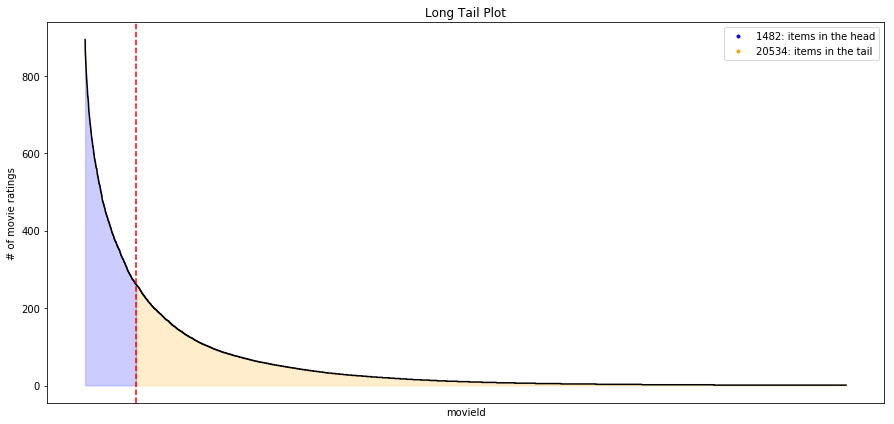

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))
recmetrics.LongTailPlot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

# Collaborative Filter Recommender
Creating a simple CF to demonstrate recommender metrics in action. I've implemented collaborative filtering using a SVD approach in the surprise package. The surprise package also takes care of the test train split. The collaborative filter transforms user-item interactions into latent space, and reconstructs the user-item matrix to impute ratings missing movie ratings. The predicted rating is the dot product between the user and movie vectors in latent space. 

In [7]:
#format data for surprise
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

In [8]:
#train SVD recommender 
algo = SVD()
algo.fit(trainset)

In [9]:
#make predictions on test set. 
test = algo.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['userId', 'movieId', 'actual', 'cf_predictions']
test.head()

,userId,movieId,actual,cf_predictions
0,90138,5464,3.5,3.705871
1,123327,508,4.0,3.762641
2,18069,2431,3.0,3.195346
3,114992,5644,5.0,3.999399
4,96750,4447,3.0,3.565483


In [10]:
#evaluate model with MSE and RMSE
print recmetrics.mse(test.actual, test.cf_predictions)
print recmetrics.rmse(test.actual, test.cf_predictions)

0.265032366660921
0.51481294337


In [11]:
#create model (matrix of predicted values)
cf_model = test.pivot_table(index='userId', columns='movieId', values='cf_predictions').fillna(0)

In [12]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [13]:
#get example prediction
get_users_predictions(156, 10, cf_model)

[2762, 527, 2028, 589, 480, 1270, 296, 1961, 1242, 293]

In [14]:
#format test data
test = test.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})
#make recommendations for all members in the test data
recs = []
for user in test.index:
    cf_predictions = get_users_predictions(user, 10, cf_model)
    recs.append(cf_predictions)
        
test['cf_predictions'] = recs
test.head()

/Users/clairelongo/Documents/Work/prof_dev/recmetrics/venv/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,actual,cf_predictions
userId,,
156,"[2049, 4, 2054, 2056, 10, 21, 22, 23, 2072, 20...","[2762, 527, 2028, 589, 480, 1270, 296, 1961, 1..."
208,"[7382, 54272, 89090, 3263, 3079, 523, 14, 2575...","[527, 1221, 1252, 5291, 904, 1304, 1213, 1178,..."
359,"[2560, 39427, 2565, 37382, 1281, 428, 3082, 78...","[260, 32657, 720, 50, 1196, 1214, 2858, 1200, ..."
394,"[1537, 6659, 3588, 3077, 6662, 665, 4617, 6666...","[296, 3134, 1252, 924, 1260, 1254, 5971, 6711,..."
572,"[2053, 4104, 4105, 2058, 11, 1036, 77837, 4814...","[318, 50, 589, 1036, 593, 293, 78499, 79008, 1..."


# Popularity Recommender
Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 movies to every user.

In [15]:
#make recommendations for all members in the test data
popularity_recs = ratings.movieId.value_counts().head(10).index.tolist()

recs = []
for user in test.index:
    pop_predictions = popularity_recs
    recs.append(pop_predictions)
        
test['pop_predictions'] = recs
test.head()

,actual,cf_predictions,pop_predictions
userId,,,
156,"[2049, 4, 2054, 2056, 10, 21, 22, 23, 2072, 20...","[2762, 527, 2028, 589, 480, 1270, 296, 1961, 1...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
208,"[7382, 54272, 89090, 3263, 3079, 523, 14, 2575...","[527, 1221, 1252, 5291, 904, 1304, 1213, 1178,...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
359,"[2560, 39427, 2565, 37382, 1281, 428, 3082, 78...","[260, 32657, 720, 50, 1196, 1214, 2858, 1200, ...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
394,"[1537, 6659, 3588, 3077, 6662, 665, 4617, 6666...","[296, 3134, 1252, 924, 1260, 1254, 5971, 6711,...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
572,"[2053, 4104, 4105, 2058, 11, 1036, 77837, 4814...","[318, 50, 589, 1036, 593, 293, 78499, 79008, 1...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."


# Random Recommender
Creating a simple random recommender to demonstrate recommender metrics in action. The random recommender simply recommends 10 random movies to every user.

In [16]:
#make recommendations for all members in the test data

recs = []
for user in test.index:
    random_predictions = ratings.movieId.sample(10).values.tolist()
    recs.append(random_predictions)
        
test['random_predictions'] = recs
test.head()

,actual,cf_predictions,pop_predictions,random_predictions
userId,,,,
156,"[2049, 4, 2054, 2056, 10, 21, 22, 23, 2072, 20...","[2762, 527, 2028, 589, 480, 1270, 296, 1961, 1...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[2134, 1305, 41573, 5872, 63062, 49276, 8636, ..."
208,"[7382, 54272, 89090, 3263, 3079, 523, 14, 2575...","[527, 1221, 1252, 5291, 904, 1304, 1213, 1178,...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[53550, 8426, 1129, 3566, 24, 3338, 3421, 1916..."
359,"[2560, 39427, 2565, 37382, 1281, 428, 3082, 78...","[260, 32657, 720, 50, 1196, 1214, 2858, 1200, ...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[910, 913, 1483, 19, 2019, 922, 223, 596, 2664..."
394,"[1537, 6659, 3588, 3077, 6662, 665, 4617, 6666...","[296, 3134, 1252, 924, 1260, 1254, 5971, 6711,...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[5010, 5171, 4142, 58, 1278, 4816, 48385, 2578..."
572,"[2053, 4104, 4105, 2058, 11, 1036, 77837, 4814...","[318, 50, 589, 1036, 593, 293, 78499, 79008, 1...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[3317, 74545, 1876, 3066, 4239, 74545, 4826, 2..."


# Recall

In [17]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [18]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])
pop_mark

[0.0007811812856029818,
 0.0012469243501449184,
 0.0016716487475918825,
 0.0019992863029036807,
 0.002298914733482367,
 0.00257813065884368,
 0.0028250539270016574,
 0.003099214482779761,
 0.0033283643206609773,
 0.0035494578701911195]

In [19]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])
random_mark

[0.0002658817282749858,
 0.00040397457204260966,
 0.0004851137312192416,
 0.0005540345207573696,
 0.000622993770250664,
 0.0006766477158868245,
 0.0007289058939441772,
 0.0007788822808948735,
 0.0008294019809846177,
 0.0008703007564396948]

In [20]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])
cf_mark

[0.0030785223090416597,
 0.006157044618083319,
 0.009235566927124978,
 0.012314089236166639,
 0.0153926115452083,
 0.018471133854249956,
 0.02154965616329162,
 0.024628178472333277,
 0.027706700781374934,
 0.0307852230904166]

# Mark Plot

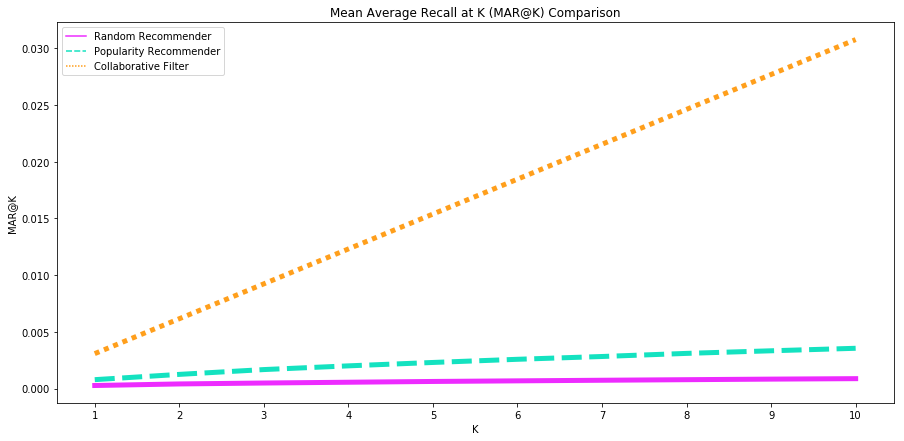

In [21]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
recmetrics.MarkPlot(mark_scores, model_names=names, k_range=index)

# Coverage

In [22]:
catalog = ratings.movieId.unique().tolist()
random_coverage = recmetrics.coverage(random_predictions, catalog)
pop_coverage = recmetrics.coverage(pop_predictions, catalog)
cf_coverage = recmetrics.coverage(cf_predictions, catalog)

# Coverage Plot

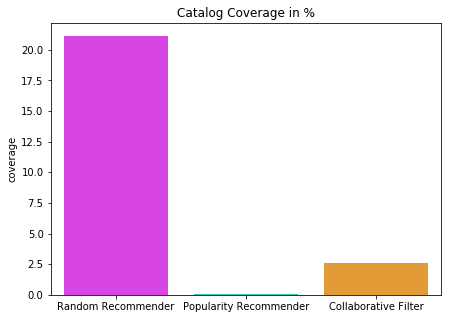

In [23]:
coverage_scores = [random_coverage, pop_coverage, cf_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(7, 5))
recmetrics.CoveragePlot(coverage_scores, model_names)

# Personalization

In [24]:
example_predictions = [
    ['1', '2', 'C', 'D'],
    ['4', '3', 'm', 'X'],
    ['7', 'B', 't', 'X']
]

In [25]:
recmetrics.personalization(predicted=example_predictions)

0.9166666666666666

# Intra-list Similarity

In [26]:
example_predictions = [
    [3, 7, 5, 9],
    [9, 6, 12, 623],
    [7, 894, 6, 623]
]

In [27]:
feature_df = movies[['Action', 'Comedy', 'Romance']]

In [28]:
recmetrics.intra_list_similarity(example_predictions, feature_df)

0.27777777777777773